In [0]:
import numpy as np
import pandas as pd 
import re
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.layers import Attention
from keras.models import Model
from keras.callbacks import EarlyStopping
import warnings
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

In [0]:
BATCH_SIZE=128
EPOCHS=100
latent_dim=256
embedding_dim=100
test_train_split=0.25

In [308]:
df = pd.read_csv('./data0.csv')
df.head(1)

,Unnamed: 0,file,text,summary
0,0,0002c17436637c4fe1837c935c04de47adb18e9a.story,Los Angeles A medical doctor Vancouver British...,NEW A Canadian doctor says she was part of a t...


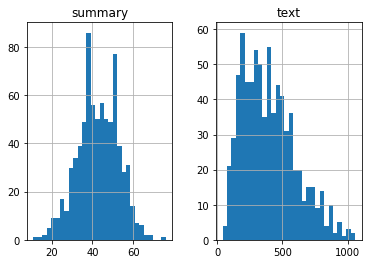

In [309]:
text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in df['text']:
      text_word_count.append(len(i.split(' ')))

for i in df['summary']:
      summary_word_count.append(len(i.split(' ')))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})

length_df.hist(bins = 30)
plt.show()

In [310]:
cnt=0
for i in df['summary']:
    if(len(i.split())<=60):
        cnt=cnt+1
print(cnt/len(df['summary']))

0.9777195281782438


In [311]:
cnt=0
for i in df['text']:
    if(len(i.split())<=600):
        cnt=cnt+1
print(cnt/len(df['text']))

0.8401048492791612


In [0]:
max_text_len=600
max_summary_len=60

In [0]:
X = np.array(df['text'])
Y = np.array(df['summary'])

In [314]:
x_tr,x_val,y_tr,y_val=train_test_split(X,Y,test_size=test_train_split,random_state=0,shuffle=True)
print(x_tr.shape)
print(x_val.shape)
print(y_tr.shape)
print(y_val.shape)

(572,)
(191,)
(572,)
(191,)


In [0]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(X))

In [316]:
thresh=3

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 59.30358678984179
Total Coverage of rare words: 6.505136067080099


In [317]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer(num_words=tot_cnt) 
x_tokenizer.fit_on_texts(list(X))

#convert text sequences into integer sequences
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1
print(x_voc)

26738


In [0]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(Y))

In [319]:
thresh=2

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 56.56853043047996
Total Coverage of rare words: 14.020296164576754


In [320]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer(num_words=tot_cnt) 
y_tokenizer.fit_on_texts(list(Y))

#convert text sequences into integer sequences
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words +1
print(y_voc)

8085


In [321]:
# Encoder
encoder_inputs = Input(shape=(max_text_len,))
#embedding layer
enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)
#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c = encoder_lstm1(enc_emb)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])
                                                          
#dense layer
decoder_dense = Dense(y_voc, activation='softmax')
# decoder_dense = Dense(y_voc, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

Model: "model_46"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_83 (InputLayer)           (None, 600)          0                                            
__________________________________________________________________________________________________
input_84 (InputLayer)           (None, None)         0                                            
__________________________________________________________________________________________________
embedding_45 (Embedding)        (None, 600, 100)     2673800     input_83[0][0]                   
__________________________________________________________________________________________________
embedding_46 (Embedding)        (None, None, 100)    808500      input_84[0][0]                   
___________________________________________________________________________________________

In [0]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [0]:
# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)

In [324]:
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

Train on 572 samples, validate on 191 samples
Epoch 1/100
572/572 [==============================] - 19s 33ms/step - loss: 8.5225 - val_loss: 6.4970
Epoch 2/100
572/572 [==============================] - 10s 17ms/step - loss: 6.0860 - val_loss: 5.9572
Epoch 3/100
572/572 [==============================] - 10s 18ms/step - loss: 5.7930 - val_loss: 5.9784
Epoch 4/100
572/572 [==============================] - 10s 17ms/step - loss: 5.7143 - val_loss: 6.0553
Epoch 5/100
572/572 [==============================] - 10s 17ms/step - loss: 5.7081 - val_loss: 5.9486
Epoch 6/100
572/572 [==============================] - 10s 17ms/step - loss: 5.6107 - val_loss: 5.8541
Epoch 7/100
572/572 [==============================] - 10s 17ms/step - loss: 5.5804 - val_loss: 6.0757
Epoch 8/100
572/572 [==============================] - 10s 18ms/step - loss: 5.5283 - val_loss: 5.8763
Epoch 9/100
572/572 [==============================] - 10s 18ms/step - loss: 5.4883 - val_loss: 5.8668
Epoch 10/100
572/572 [=====

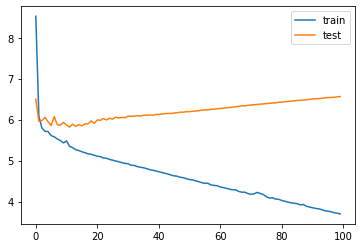

In [325]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

## Inference Model

In [0]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

In [0]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))
decoder_state_inputs = [decoder_state_input_h, decoder_state_input_c]

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_state_inputs)

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_outputs2) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [334]:
decoder_model.summary()

Model: "model_50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_84 (InputLayer)           (None, None)         0                                            
__________________________________________________________________________________________________
embedding_46 (Embedding)        (None, None, 100)    808500      input_84[0][0]                   
__________________________________________________________________________________________________
input_88 (InputLayer)           (None, 256)          0                                            
__________________________________________________________________________________________________
input_89 (InputLayer)           (None, 256)          0                                            
___________________________________________________________________________________________

In [0]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [0]:
def decode_sequence(input_seq): 
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    # print(e_out)
    target_seq = np.zeros((1,1))
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c]) 
      sampled_token_index = np.argmax(output_tokens[0, -1, :])
      # print(sampled_token_index)
      if (sampled_token_index != 0 ):
        sampled_token = reverse_target_word_index[sampled_token_index]
        decoded_sentence += ' '+sampled_token
      else :
        stop_condition = True
      if (len(decoded_sentence.split()) >= (max_summary_len-1)):
              stop_condition = True
       # Update the target sequence (of length 1).
      target_seq = np.zeros((1,1))
      target_seq[0, 0] = sampled_token_index

      # Update internal states
      e_h, e_c = h, c
    return decoded_sentence

In [340]:
for i in range(0,5):
    print("Article:",seq2text(x_tr[i]))
    print("Original summary:",seq2summary(y_tr[i]))
    print("Generated summary:",decode_sequence(x_tr[i].reshape(1,max_text_len)))
    print("\n")

Article: scores people without bread day kill syrian warplane bombed bakery western village halfaya opposition activist say sunday more 100 people kill opposition local coordination committees syria say the death toll could rise activist group say an activist oversaw burial many body say least 109 people die hassan alrajb told cnn 69 people identify bury 15 others laid rest without idd at least 25 body still site hospital worker say road cut unable reach bakery say the hospital handle wound say an lcc activist told cnn go scene there dozen dead thrown street the resident shock state fear it chaotic mahmoud alawy say videos post social medium purport show aftermath attack many body limb apparently blown others lay bloody street rubble strewn sidewalk uniformed free syrian army soldier civilian scramble pull survivor carnage cnn independently confirm government opposition report syria government restrict access journalist the town lack ingredient bread week aid group deliver provision sa